<a href="https://colab.research.google.com/github/rhemish/ML_and_RL_Projects/blob/main/Reinforcement%20Learning%20in%20a%20Modified%20Blackjack%20Environment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Date:** July 16, 2025

#Modified Black Jack

## Reinforcement Learning in a Modified Blackjack Environment

This notebook applies **Monte Carlo Control** and **SARSA(lambda)** to a simplified, non-standard version of the Blackjack game.  
The goal is to learn an optimal policy for the player using model-free reinforcement learning methods.

The results include:
- A value function plot from Monte Carlo learning
- Error analysis of SARSA(lambda) across different lambda values

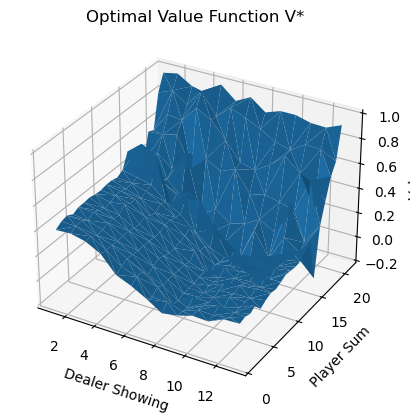

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random

#Defining the Constants for the game setup
N0 = 100
ACTIONS = [0, 1]  #0 = Stick, 1 = Hit
MAX_SUM = 21
MIN_SUM = 1

def draw_card():
    #Draw a card: values 1–13 include J as 11, Q as 12 and K as 13)
    value = np.random.randint(1, 14)
    color = 'black' if np.random.rand() < 2/3 else 'red'
    return value if color == 'black' else -value

#Drawing a black card to initialize
def draw_black_card():
    return np.random.randint(1, 14)

def init_game():
    player_sum = draw_black_card()
    dealer_card = draw_black_card()
    return dealer_card, player_sum

#Environment step function
def step(state, action):
    dealer_card, player_sum = state

    if action == 1:
        card = draw_card()
        player_sum += card
        if player_sum < MIN_SUM or player_sum > MAX_SUM:
            return None, -1, True
        return (dealer_card, player_sum), 0, False

    dealer_sum = dealer_card
    while dealer_sum < 17:
        dealer_sum += draw_card()
        if dealer_sum < MIN_SUM or dealer_sum > MAX_SUM:
            return None, 1, True

    if player_sum > dealer_sum:
        return None, 1, True
    elif player_sum < dealer_sum:
        return None, -1, True
    else:
        return None, 0, True

def get_action(Q, state, N_s):
    epsilon = N0 / (N0 + N_s[state])
    if np.random.rand() < epsilon:
        return np.random.choice(ACTIONS)
    else:
        return np.argmax([Q[state, a] for a in ACTIONS])

#Monte Carlo control algorithm with first-visit updates
def monte_carlo_control(num_episodes=500000):
    Q = defaultdict(float)
    N_sa = defaultdict(int)
    N_s = defaultdict(int)

    for _ in range(num_episodes):
        state = init_game()
        episode = []
        done = False

        while not done:
            N_s[state] += 1
            action = get_action(Q, state, N_s)
            next_state, reward, done = step(state, action)
            episode.append((state, action, reward))
            state = next_state if not done else state

        G = episode[-1][2]
        visited = set()
        for state, action, _ in episode:
            if (state, action) not in visited:
                visited.add((state, action))
                N_sa[(state, action)] += 1
                alpha = 1 / N_sa[(state, action)]
                Q[(state, action)] += alpha * (G - Q[(state, action)])

    return Q

Q_star = monte_carlo_control()

V_star = defaultdict(float)
for (s, a), q in Q_star.items():
    if s not in V_star or q > V_star[s]:
        V_star[s] = q

X, Y, Z = [], [], []
for (dealer_card, player_sum), value in V_star.items():
    X.append(dealer_card)
    Y.append(player_sum)
    Z.append(value)

#Value function plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(X, Y, Z, linewidth=0.2, antialiased=True)
ax.set_xlabel('Dealer Showing')
ax.set_ylabel('Player Sum')
ax.set_zlabel('Value')
plt.title('Optimal Value Function V*')
plt.show()

### Monte Carlo Control – Optimal Value Function

This 3D surface plot shows the optimal value function **V\*(s)** learned using Monte Carlo Control.  
It illustrates the expected return from each game state, based on the player's current sum and the dealer's showing card, under the optimal policy.

In [ ]:
#Sarsa (lambda) Implementation
def sarsa_lambda(Q_star, lambdas=np.arange(0, 1.1, 0.1), episodes=1000):
    mse_by_lambda = {}
    learning_curves = {}

    for lambd in lambdas:
        Q = defaultdict(float)
        N_sa = defaultdict(int)
        N_s = defaultdict(int)
        mse_per_episode = []

        for ep in range(episodes):
            state = init_game()
            episode = []
            done = False
            while not done:
                N_s[state] += 1
                action = get_action(Q, state, N_s)
                next_state, reward, done = step(state, action)
                episode.append((state, action, reward))
                state = next_state if not done else state

            T = len(episode)
            G = np.zeros(T)
            for t in range(T):
                G_t = 0.0
                for n in range(t, T):
                    if n + 1 < T:
                        a_next = episode[n+1][1]
                        s_next = episode[n+1][0]
                        G_t += (lambd ** (n - t)) * (episode[n][2] + Q[s_next, a_next])
                    else:
                        G_t += (lambd ** (n - t)) * episode[n][2]
                G[t] = G_t

            visited = set()
            for t, (s, a, _) in enumerate(episode):
                if (s, a) not in visited:
                    visited.add((s, a))
                    N_sa[(s, a)] += 1
                    alpha = 1 / N_sa[(s, a)]
                    Q[(s, a)] += alpha * (G[t] - Q[(s, a)])

            if lambd in [0.0, 1.0]:
                mse = 0.0
                for (s, a), q in Q_star.items():
                    mse += (Q[(s, a)] - q) ** 2
                mse_per_episode.append(mse)

        final_mse = 0.0
        for (s, a), q in Q_star.items():
            final_mse += (Q[(s, a)] - q) ** 2
        mse_by_lambda[lambd] = final_mse
        if lambd in [0.0, 1.0]:
            learning_curves[lambd] = mse_per_episode

    return mse_by_lambda, learning_curves

mse_by_lambda, learning_curves = sarsa_lambda(Q_star)

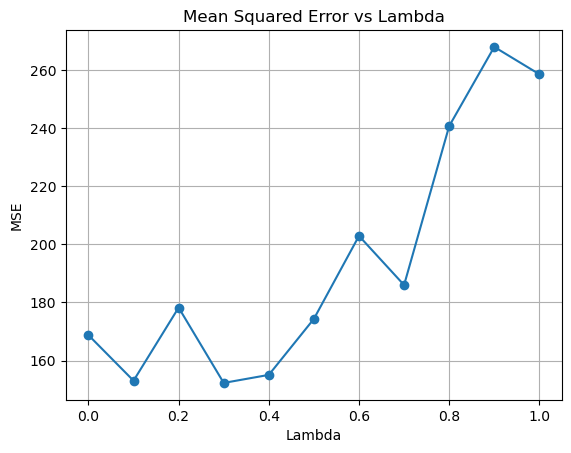

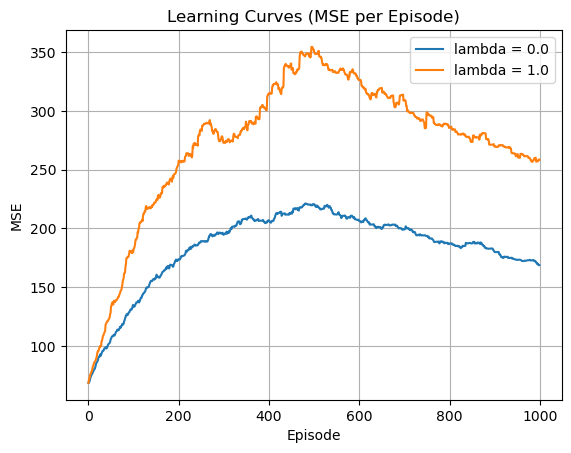

In [ ]:
import matplotlib.pyplot as plt

#MSE vs lambda
lambdas = list(mse_by_lambda.keys())
mses = list(mse_by_lambda.values())
plt.plot(lambdas, mses, marker='o')
plt.title("Mean Squared Error vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("MSE")
plt.grid(True)
plt.show()

#Learning curves for lambda = 0 and 1
for lmbd in learning_curves:
    plt.plot(learning_curves[lmbd], label=f"lambda = {lmbd}")
plt.title("Learning Curves (MSE per Episode)")
plt.xlabel("Episode")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()


### SARSA (lambda) Evaluation – Mean Squared Error Analysis

The first plot shows the **mean squared error (MSE)** between the SARSA (lambda)-learned action-value function and the Monte Carlo baseline **Q\*** across different values of **lambda**.  
Lower λ values tend to result in smaller MSE, suggesting better approximation of the true value function.

The second plot tracks how MSE evolves during training for **lambda = 0** and **lambda = 1**.  
It shows that the **lower lambda** led to **more stable and accurate convergence**, while **lambda = 1** shows higher variance and error.
